In [304]:
import tensorflow as tf

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [305]:
def repeat_input_and_concat_cartesian_product_multiplied(input):
  return tf.concat([input, tf.repeat(input, repeats=input.shape[-1], axis=-1) * tf.tile(input, [1] * (len(input.shape) - 1) + [input.shape[-1]])], axis=-1)

assert tf.math.reduce_all((tf.equal(repeat_input_and_concat_cartesian_product_multiplied(tf.constant([1,2,3])), tf.constant([1,2,3,1,2,3,2,4,6,3,6,9]))))
assert tf.math.reduce_all((tf.equal(repeat_input_and_concat_cartesian_product_multiplied(tf.constant([[1,2,3],[4,5,6]])), tf.constant([[1,2,3,1,2,3,2,4,6,3,6,9],[4,5,6,16, 20, 24, 20, 25, 30, 24, 30, 36]]))))

In [306]:
import tensorflow as tf

def generate_circles(circles_count, width, height):
  """
  Generates circles with random x, y and radius values that are wholly inside the image.

  Args:
  circles_count: int, number of circles to generate.
  width: int, width of the image.
  height: int, height of the image.

  Returns:
  A tensor of shape (circles_count, 3) where the last dimension is [x, y, radius].
  """
  width = tf.cast(width, tf.float32)
  height = tf.cast(height, tf.float32)
  x = tf.random.uniform([circles_count], maxval=width, dtype=tf.float32)
  y = tf.random.uniform([circles_count], maxval=height, dtype=tf.float32)
  radius = tf.random.uniform([circles_count], minval=0, maxval=tf.minimum(width, height), dtype=tf.float32)
  circles = tf.stack([x, y, radius], axis=1)
  return circles


In [307]:
import tensorflow as tf

def generate_circle_images(circles, width, height):
  """
  Generates a grayscale images of given width and height with one circle per image.

  Args:
  circles: tensor of shape (n, 3), the circles with [x, y, radius] values.
  width: int, width of the image.
  height: int, height of the image.

  Returns:
  A tensor of shape (n, height, width) representing the grayscale image.
  """

  # create a meshgrid of x and y coordinates
  x, y = tf.meshgrid(tf.linspace(0.0, width-1, width), tf.linspace(0.0, height-1, height))

  x = tf.cast(x, tf.float32)
  y = tf.cast(y, tf.float32)

  # repeat x for every image
  x = tf.tile(x[tf.newaxis, ...], [circles.shape[0], 1, 1])

  # repeat y for every image
  y = tf.tile(y[tf.newaxis, ...], [circles.shape[0], 1, 1])

  # repeat the circles for each pixel
  circles = tf.tile(circles[:, tf.newaxis, tf.newaxis, :], [1, width, height, 1])

  # compute the distance from each pixel to each circle
  distance = tf.sqrt(tf.square(x - circles[..., 0]) + tf.square(y - circles[..., 1]))

  # create a mask for each circle
  mask = distance <= circles[..., 2]

  # convert the mask to a float32 tensor
  mask = tf.cast(mask, tf.float32)

  # add the channel dimension to the tensor
  # mask = tf.expand_dims(mask, axis=-1)

  return mask


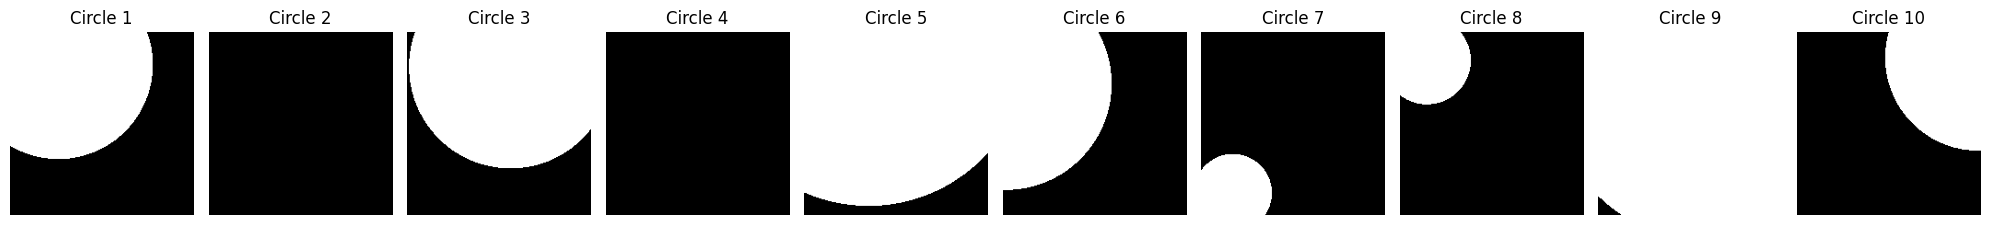

In [308]:
import matplotlib.pyplot as plt

circle_count = 10
width = 200
height = 200
circles = generate_circles(circle_count, width, height)
images = generate_circle_images(circles, width, height)

fig, axs = plt.subplots(1, circle_count, figsize=(20, 4))
for i, ax in enumerate(axs.flat):
  ax.imshow(images[i], cmap='gray')
  ax.set_title(f'Circle {i+1}')
  ax.axis('off')
plt.tight_layout()
plt.show()


In [309]:
latent_dimensions = 3 # intuitively x, y, radius of a circle
sampling_dimensions = 2 # intuitively x, y of a pixel

# this model is decoder from the latent space to the image space
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, None, sampling_dimensions + latent_dimensions,)), # pixel x, y, circle x, y, radius
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu),
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.mean_squared_error)

model.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, None, None, 10)    60        
                                                                 
 dense_149 (Dense)           (None, None, None, 10)    110       
                                                                 
 dense_150 (Dense)           (None, None, None, 10)    110       
                                                                 
 dense_151 (Dense)           (None, None, None, 10)    110       
                                                                 
 dense_152 (Dense)           (None, None, None, 10)    110       
                                                                 
 dense_153 (Dense)           (None, None, None, 10)    110       
                                                                 
 dense_154 (Dense)           (None, None, None, 10)  

In [310]:
# generate trainign data
traning_samples_count = 1000
image_width = 100
image_height = 100
circles = generate_circles(traning_samples_count, image_width, image_height)
images = generate_circle_images(circles, image_width, image_height)

In [311]:
# create a tensor of shape (training_samples_count * image_width * image_height, 2 + 3)
# where the last dimension is [pixel_x, pixel_y, circle_x, circle_y, circle_radius]

# repeat the circles for each pixel
latent = tf.tile(circles[:, tf.newaxis, tf.newaxis, :], [1, image_width, image_height, 1])
# create a meshgrid of x and y coordinates
x, y = tf.meshgrid(tf.linspace(0.0, image_width-1, image_width), tf.linspace(0.0, image_height-1, image_height))
# repeat x for every circle
x = tf.expand_dims(tf.cast(tf.tile(x[tf.newaxis, ...], [circles.shape[0], 1, 1]), dtype=tf.float32), axis=-1)
# repeat y for every circle
y = tf.expand_dims(tf.cast(tf.tile(y[tf.newaxis, ...], [circles.shape[0], 1, 1]), dtype=tf.float32), axis=-1)
# add the pixel coordinates to the circles
inputs = tf.concat([x, y, latent], axis=-1)

outputs = images

# Train the model
history = model.fit(inputs, outputs, epochs=10, batch_size=1)


Epoch 1/10
1000/1000 [==============================] - 5s 4ms/step - loss: 0.1143
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0365
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0240
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0157
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0131
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0115
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0103
Epoch 8/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0103
Epoch 9/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0099
Epoch 10/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0096


1/1 [==============================] - 0s 101ms/step


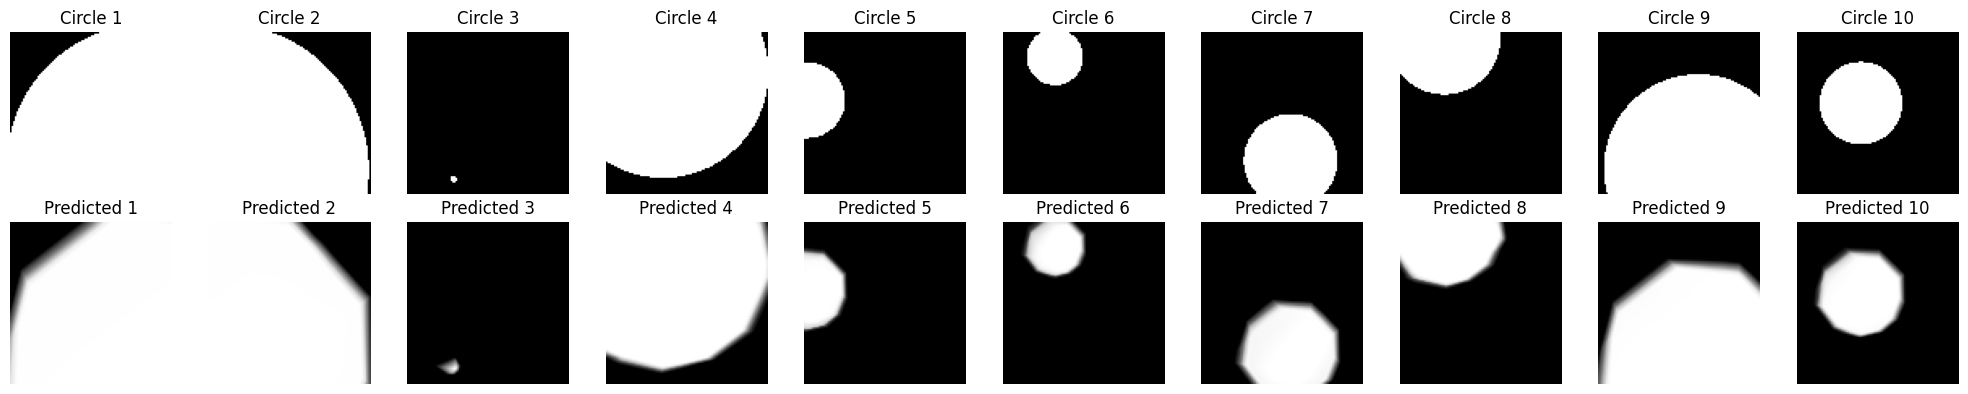

In [320]:
page_size = 10
page = 3

predictions = model.predict(inputs[page*page_size:page*page_size+page_size])
predicted_images = tf.reshape(predictions, [-1, image_width, image_height])

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i, ax in enumerate(axs[0]):
  ax.imshow(images[page*page_size + i], cmap='gray')
  ax.set_title(f'Circle {i+1}')
  ax.axis('off')
for i, ax in enumerate(axs[1]):
  ax.imshow(predicted_images[i], cmap='gray')
  ax.set_title(f'Predicted {i+1}')
  ax.axis('off')
plt.tight_layout()
plt.show()
